# Сезонная структура потребления контента 

Допустим, мы наблюдаем какой-либо процесс с ярко выраженной сезонностью,  например, процесс потребления образовательного видеоконтента (хотя печь может идти о процессах портребления любого типа, лищь бы сезонность была выражена достаточно ярко). Интересны вопросы: 

1. Идентична ли структура потребления в период высокого спроса (зиняя сессия, всем нужно срочно учиться) структуре потребления в период низкого спроса (август, летние каникулы, учебный конент никому не нужен)?

2. можно ли обучать прогнозирующие модели на сезонах одного типа, а применять для прогнозирования к сезонам другого типа?

С этими вопросами мы здесь и будем работать.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl

## Чтение данных

Данные представлены по годам: с 2019 по 2023. Есть данные за каждый из январей (высокий сезон) и за каждый из августов (низкий сезон). Всего получается 10 однотипных датафреймов: везде признаки одинаковые и следуют в одном и том же порядке.

In [2]:
df_2019_08 = pd.read_csv('data/2019.08.csv')
df_2020_08 = pd.read_csv('data/2020.08.csv')
df_2021_08 = pd.read_csv('data/2021.08.csv')
df_2022_08 = pd.read_csv('data/2022.08.csv')
df_2023_08 = pd.read_csv('data/2023.08.csv')


df_2019_01 = pd.read_csv('data/2019.01.csv')
df_2020_01 = pd.read_csv('data/2020.01.csv')
df_2021_01 = pd.read_csv('data/2021.01.csv')
df_2022_01 = pd.read_csv('data/2022.01.csv')
df_2023_01 = pd.read_csv('data/2023.01.csv')

## Разведочный анализ

In [3]:
# Смотрим на струткуру датафрейма. Остальные точно такие же
df_2023_01

,Новые комментарии,Поделились,"Отметки ""Не нравится""","Отметки ""Нравится""",Средний процент просмотра (%),Просмотры,Время просмотра (часы),Показы,CTR для значков видео (%)
0,2.0,32.0,1.0,38.0,12.94,1892.0,94.7677,5994.0,16.12
1,2.0,1.0,1.0,7.0,30.99,362.0,15.0828,2356.0,9.08
2,1.0,0.0,0.0,1.0,17.17,45.0,1.6504,668.0,4.34
3,1.0,1.0,0.0,1.0,27.86,164.0,6.6509,1115.0,9.15
4,1.0,3.0,3.0,6.0,20.29,541.0,20.3997,2254.0,15.88
...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,30.36,6.0,0.1219,321.0,1.25
496,0.0,0.0,0.0,0.0,58.16,24.0,0.3528,622.0,1.77
497,0.0,0.0,0.0,0.0,0.96,1.0,0.0008,52.0,0.00
498,0.0,0.0,0.0,2.0,21.83,37.0,1.0950,325.0,4.00


In [4]:
# Смотрим на числовые характеристики
df_2023_01.describe()

,Новые комментарии,Поделились,"Отметки ""Не нравится""","Отметки ""Нравится""",Средний процент просмотра (%),Просмотры,Время просмотра (часы),Показы,CTR для значков видео (%)
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.048000,0.522000,0.068000,1.14000,33.024520,70.996000,2.746957,555.144000,4.528100
std,0.231956,2.225178,0.368303,3.26093,16.050614,184.063257,8.395691,843.541223,3.496724
min,0.000000,0.000000,0.000000,-1.00000,0.960000,1.000000,0.000800,19.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,22.662500,6.000000,0.107200,109.000000,1.897500
50%,0.000000,0.000000,0.000000,0.00000,30.655000,15.000000,0.352750,322.000000,3.685000
75%,0.000000,0.000000,0.000000,1.00000,41.267500,51.250000,1.553425,618.250000,6.172500
max,2.000000,32.000000,5.000000,38.00000,141.990000,2061.000000,99.291900,9558.000000,17.800000


Но вот объем данных может отличаться из-за того, что в какие-то года возникало пропуски на стороне хостинга. И получается, что объем варьируется от 494 до 500. Но это не важно. Данные могли би еще больше отличаться. Допустим, мы учим модель на 500 записях, а тестируем  на другом датафреме на 10 записях: ни у что? Это не играет никакой роли. Тем более, что объемы примерно равны. Мы лишь отмечаем, что пропуски в данных есть.

In [5]:
print('Объем данных 2019_01', len(df_2019_01))
print('Объем данных 2019_08', len(df_2019_08))
print('')

print('Объем данных 2020_01', len(df_2020_01))
print('Объем данных 2020_08', len(df_2020_08))
print('')

print('Объем данных 2021_01', len(df_2021_01))
print('Объем данных 2021_08', len(df_2021_08))
print('')

print('Объем данных 2022_01', len(df_2022_01))
print('Объем данных 2022_08', len(df_2022_08))
print('')

print('Объем данных 2023_01', len(df_2023_01))
print('Объем данных 2023_08', len(df_2023_08))

Объем данных 2019_01 500
Объем данных 2019_08 499

Объем данных 2020_01 500
Объем данных 2020_08 494

Объем данных 2021_01 495
Объем данных 2021_08 500

Объем данных 2022_01 499
Объем данных 2022_08 498

Объем данных 2023_01 500
Объем данных 2023_08 498


## Сравнение средних значений

Здесь мы агрегируем сведения о средних значениях признаков в каждый из месяцев.

In [6]:
df_list = [df_2019_01, df_2019_08, 
           df_2020_01, df_2020_08, 
           df_2021_01, df_2021_08,
           df_2022_01, df_2022_08,
           df_2023_01, df_2023_08]

df_mean = pd.DataFrame()

cols = ['01.19', '08.19', '01.20', '08.20', '01.21', '08.21', '01.22', '08.22', '01.23', '08.23']

for i in range(len(cols)):
     df_mean[cols[i]] = df_list[i].describe().T['mean']

df_mean

,01.19,08.19,01.20,08.20,01.21,08.21,01.22,08.22,01.23,08.23
Новые комментарии,0.686000,0.006012,0.086000,0.014170,0.098990,0.022000,0.060120,0.034137,0.048000,0.014056
Поделились,0.456000,0.126253,0.654000,0.056680,0.648485,0.058000,0.476954,0.128514,0.522000,0.046185
"Отметки ""Не нравится""",0.164000,0.028056,0.236000,0.024291,0.145455,0.026000,0.150301,0.022088,0.068000,0.008032
"Отметки ""Нравится""",1.344000,0.248497,1.490000,0.220648,1.371717,0.364000,1.354709,0.538153,1.140000,0.212851
Средний процент просмотра (%),32.405440,41.361082,36.443500,40.332611,35.124263,38.141640,35.263086,36.500462,33.024520,33.680482
Просмотры,96.898000,16.543086,100.352000,17.514170,67.577778,14.180000,62.591182,16.638554,70.996000,12.401606
Время просмотра (часы),4.435441,0.819039,4.507573,0.827117,2.829374,0.673097,2.816910,0.622618,2.746957,0.470902
Показы,778.742000,200.811623,903.220000,217.048583,780.098990,172.802000,486.052104,411.369478,555.144000,127.775100
CTR для значков видео (%),3.887260,2.930782,3.564380,2.874352,3.145798,4.114700,4.232124,3.017791,4.528100,4.623313


## Нормализация данных

Масштаб данных отличается на порядки. Где-то это единицы, а где-то тысячи. Поэтому мы нормируем данные про помощи стндартизации. Но  здесь есть один нюанс. Мы не можем нормировать каждый датафрейм отдельно (тогда там всегда будет получаться центрированное облако, а это не так, потому что фрагменты относящиеся к высокому и низкому сезону, смещены друг относительно друга).

Поэтому мы сначала объединяем данные в один датафрейм, а для этого предварительно добавляем столбцы, помечающие номер года и номер месяца, чтобы потом развести их снова в 10 датафреймов.

In [17]:
df_list_01 = [df_2019_01, df_2020_01, df_2021_01, df_2022_01, df_2023_01]
df_list_08 = [df_2019_08, df_2020_08, df_2021_08, df_2022_08, df_2023_08]

# Добавляем номера месяцев и лет
for i in range(len(df_list_01)):
    df_list_01[i]['Год'] = 2019 + i
    df_list_01[i]['Месяц'] = 1

for i in range(len(df_list_08)):
    df_list_08[i]['Год'] = 2019 + i
    df_list_08[i]['Месяц'] = 8

# Конкатенируем
df_general = pd.concat([df_2019_01, df_2020_01, df_2021_01, df_2022_01, df_2023_01,
                        df_2019_08, df_2020_08, df_2021_08, df_2022_08, df_2023_08])

# Выводим месяцы и годы в буфер, потому что они должны отстаься самими собой, а не быть нормированными
d = df_general.drop(columns = ['Год', 'Месяц'])
e = df_general[['Год', 'Месяц']]

# Стандартицируем данные
d = (d - d.mean())/d.std()

# Возвращаем месяцы и годы
d[['Год', 'Месяц']] = e

# Разводим данные снова в 10 датафреймов
d_2019_01 = d.loc[(d['Год'] == 2019) & (d['Месяц'] == 1)].drop(columns = ['Год', 'Месяц'])
d_2019_08 = d.loc[(d['Год'] == 2019) & (d['Месяц'] == 8)].drop(columns = ['Год', 'Месяц'])

d_2020_01 = d.loc[(d['Год'] == 2020) & (d['Месяц'] == 1)].drop(columns = ['Год', 'Месяц'])
d_2020_08 = d.loc[(d['Год'] == 2020) & (d['Месяц'] == 8)].drop(columns = ['Год', 'Месяц'])

d_2021_01 = d.loc[(d['Год'] == 2021) & (d['Месяц'] == 1)].drop(columns = ['Год', 'Месяц'])
d_2021_08 = d.loc[(d['Год'] == 2021) & (d['Месяц'] == 8)].drop(columns = ['Год', 'Месяц'])

d_2022_01 = d.loc[(d['Год'] == 2022) & (d['Месяц'] == 1)].drop(columns = ['Год', 'Месяц'])
d_2022_08 = d.loc[(d['Год'] == 2022) & (d['Месяц'] == 8)].drop(columns = ['Год', 'Месяц'])

d_2023_01 = d.loc[(d['Год'] == 2023) & (d['Месяц'] == 1)].drop(columns = ['Год', 'Месяц'])
d_2023_08 = d.loc[(d['Год'] == 2023) & (d['Месяц'] == 8)].drop(columns = ['Год', 'Месяц'])

# И повторяем процедуру агрегации из первой ячейки, но уже по отношению к нормированным данным
df_list = [d_2019_01, d_2019_08, 
           d_2020_01, d_2020_08, 
           d_2021_01, d_2021_08,
           d_2022_01, d_2022_08,
           d_2023_01, d_2023_08]

df_mean = pd. DataFrame()

cols = ['01.19', '08.19', '01.20', '08.20', '01.21', '08.21', '01.22', '08.22', '01.23', '08.23']

for i in range(len(cols)):
     df_mean[cols[i]] = df_list[i].describe().T['mean']

df_mean

,01.19,08.19,01.20,08.20,01.21,08.21,01.22,08.22,01.23,08.23
Новые комментарии,1.599100,-0.279445,-0.058469,-0.256907,-0.022583,-0.235276,-0.129965,-0.201748,-0.163448,-0.257222
Поделились,0.094663,-0.130682,0.229973,-0.178226,0.226204,-0.177324,0.108982,-0.129136,0.139766,-0.185399
"Отметки ""Не нравится""",0.144952,-0.111952,0.281016,-0.119066,0.109905,-0.115837,0.119063,-0.123229,-0.036467,-0.149793
"Отметки ""Нравится""",0.198146,-0.223364,0.254322,-0.234079,0.208811,-0.178922,0.202267,-0.111915,0.119654,-0.237079
Средний процент просмотра (%),-0.206964,0.278433,0.011900,0.222690,-0.059603,0.103939,-0.052079,0.014987,-0.173409,-0.137856
Просмотры,0.371449,-0.234192,0.397483,-0.226873,0.150460,-0.252003,0.112876,-0.233473,0.176224,-0.265407
Время просмотра (часы),0.345376,-0.184214,0.355939,-0.183031,0.110182,-0.205586,0.108357,-0.212978,0.098113,-0.235196
Показы,0.365076,-0.304191,0.509227,-0.285388,0.366648,-0.336627,0.026129,-0.060356,0.106141,-0.388770
CTR для значков видео (%),0.064065,-0.251914,-0.042601,-0.270556,-0.180882,0.139201,0.177993,-0.223170,0.275771,0.307225


## Коэффициенты рeгрeссионных моделей

Двльше мы учим 10 моделей: 5 на январях, 5 на августах. Целевая функция всегда 'Время просмотра (часы)'. Остальные признаки всегда предикторы и всегда следуют в одном и том же порядке. А когда у нас есть 10 обученых моделей, мы можем сравнить их коэффициенты: если они примерно равны, то это значит, что в разные периоды важными и не важными оставались одни и те же факторы, то есть, структура потебления конента оставалась неизменной. Если они окажутся существенно разными, значит, стркутура потребления поменялась. 

In [19]:
# Учим модели

name = 'Время просмотра (часы)'

# Августы

X_2019_08 = d_2019_08.drop(columns = [name]).to_numpy()
y_2019_08 = d_2019_08[name].to_numpy()

X_2020_08 = d_2020_08.drop(columns = [name]).to_numpy()
y_2020_08 = d_2020_08[name].to_numpy()

X_2021_08 = d_2021_08.drop(columns = [name]).to_numpy()
y_2021_08 = d_2021_08[name].to_numpy()

X_2022_08 = d_2022_08.drop(columns = [name]).to_numpy()
y_2022_08 = d_2022_08[name].to_numpy()

X_2023_08 = d_2023_08.drop(columns = [name]).to_numpy()
y_2023_08 = d_2023_08[name].to_numpy()

model_2019_08 = skl.LinearRegression()
model_2019_08.fit(X_2019_08, y_2019_08)

model_2020_08 = skl.LinearRegression()
model_2020_08.fit(X_2020_08, y_2020_08)

model_2021_08 = skl.LinearRegression()
model_2021_08.fit(X_2021_08, y_2021_08)

model_2022_08 = skl.LinearRegression()
model_2022_08.fit(X_2022_08, y_2022_08)

model_2023_08 = skl.LinearRegression()
model_2023_08.fit(X_2023_08, y_2023_08)

# Январи

X_2019_01 = d_2019_01.drop(columns = [name]).to_numpy()
y_2019_01 = d_2019_01[name].to_numpy()

X_2020_01 = d_2020_01.drop(columns = [name]).to_numpy()
y_2020_01 = d_2020_01[name].to_numpy()

X_2021_01 = d_2021_01.drop(columns = [name]).to_numpy()
y_2021_01 = d_2021_01[name].to_numpy()

X_2022_01 = d_2022_01.drop(columns = [name]).to_numpy()
y_2022_01 = d_2022_01[name].to_numpy()

X_2023_01 = d_2023_01.drop(columns = [name]).to_numpy()
y_2023_01 = d_2023_01[name].to_numpy()

model_2019_01 = skl.LinearRegression()
model_2019_01.fit(X_2019_01, y_2019_01)

model_2020_01 = skl.LinearRegression()
model_2020_01.fit(X_2020_01, y_2020_01)

model_2021_01 = skl.LinearRegression()
model_2021_01.fit(X_2021_01, y_2021_01)

model_2022_01 = skl.LinearRegression()
model_2022_01.fit(X_2022_01, y_2022_01)

model_2023_01 = skl.LinearRegression()
model_2023_01.fit(X_2023_01, y_2023_01)

# Выводим коэффициенты
model_coef_list = [model_2019_01.coef_, model_2019_08.coef_, 
                   model_2020_01.coef_, model_2020_08.coef_,
                   model_2021_01.coef_, model_2021_08.coef_,
                   model_2022_01.coef_, model_2022_08.coef_,
                   model_2023_01.coef_, model_2023_08.coef_
                  ]
           
# Объединяем коэффициенты в датафрейм для нагладности
df_coef = pd. DataFrame(index = ['Новые комментарии', 'Поделились', 'Отметки "Не нравится"',
                                 'Отметки "Нравится"', 'Средний процент просмотра (%)', 'Просмотры', 
                                 'Показы', 'CTR для значков видео (%)'])

cols = ['01.19', '08.19', '01.20', '08.20', '01.21', '08.21', '01.22', '08.22', '01.23', '08.23']

for i in range(len(cols)):
     df_coef[cols[i]] = model_coef_list[i]

df_coef

,01.19,08.19,01.20,08.20,01.21,08.21,01.22,08.22,01.23,08.23
Новые комментарии,-0.008317,0.112934,-0.087619,-0.024341,-0.003016,0.036092,-0.026819,-0.020795,-0.011732,-0.000248
Поделились,0.227002,-0.025921,0.035993,0.014661,0.101229,-0.003565,0.063910,-0.000434,0.176867,-0.011652
"Отметки ""Не нравится""",0.008367,-0.016185,-0.039600,0.055303,-0.039800,-0.021890,-0.087893,0.032184,0.142719,0.025788
"Отметки ""Нравится""",0.154771,0.092097,0.215623,0.013184,0.218496,0.048777,0.021275,0.029344,0.180877,-0.001726
Средний процент просмотра (%),0.055217,0.011158,0.062376,0.013490,0.026333,0.009155,0.016955,0.009332,0.037460,0.008793
Просмотры,0.909747,0.973188,0.717412,0.879359,0.673267,0.882342,1.006940,0.823901,0.379098,0.750668
Показы,-0.081222,0.115283,0.186566,0.174796,-0.036251,0.088487,0.052708,-0.022004,0.189061,0.073899
CTR для значков видео (%),-0.064563,-0.007412,-0.049338,-0.008279,-0.041435,0.004889,-0.046733,0.010833,-0.015032,0.004107


## Структура потребления контента

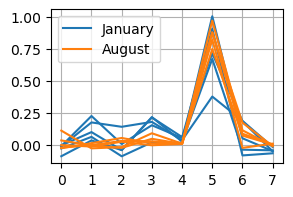

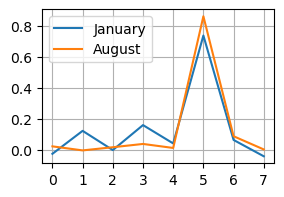

In [20]:
# Визуализируем коэффициенты моделей в виде кривых (точнее, ломаных)
# По горизонтали номер предиктора, по вертикали величина коэффициента
plt.figure(figsize = (3, 2))

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

plt.grid()

plt.plot(model_2019_01.coef_, label = 'January', color = '#1f77b4')
plt.plot(model_2020_01.coef_, color = '#1f77b4')
plt.plot(model_2021_01.coef_, color = '#1f77b4')
plt.plot(model_2022_01.coef_, color = '#1f77b4')
plt.plot(model_2023_01.coef_, color = '#1f77b4')



plt.plot(model_2019_08.coef_, label = 'August', color = '#ff7f0e')
plt.plot(model_2020_08.coef_, color = '#ff7f0e')
plt.plot(model_2021_08.coef_, color = '#ff7f0e')
plt.plot(model_2022_08.coef_, color = '#ff7f0e')
plt.plot(model_2023_08.coef_, color = '#ff7f0e')

plt.legend()

#plt.savefig('Регрессионные коэффициенты по годам.png', dpi=300, bbox_inches = 'tight')

plt.show()

# Усредняем модели на январях и августах
model_coef_01 = (model_2019_01.coef_ + model_2020_01.coef_ + model_2021_01.coef_ + model_2022_01.coef_ + model_2023_01.coef_)/5
model_coef_08 = (model_2019_08.coef_ + model_2020_08.coef_ + model_2021_08.coef_ + model_2022_08.coef_ + model_2023_08.coef_)/5

# Рисуем усредненную картинку
plt.figure(figsize = (3, 2))

plt.grid()

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

plt.plot(model_coef_01, label = 'January', color = '#1f77b4')
plt.plot(model_coef_08, label = 'August', color = '#ff7f0e')

plt.legend()

#plt.savefig('Усредненные регрессионные коэффициенты.png', dpi=300, bbox_inches = 'tight')

plt.show()

## Прогноз потребления контента

Проводим перекресное применение моделей и вычисляем возникающие при это оценки. 

Модель, обученную на январе 2021 применяем к данным за январь 2022, потом за январь 2023 и так далее, наконец, применяем ее к данным за август 2023. И так для всех моделей. Всего на 10 моделях получается 100 таких пар, которые мы объединяем в один датафрейм. 

В качестве индекса указан период обучения модели, а столбцы означают период применения. 

In [14]:
cols = ['01.19', '01.20', '01.21', '01.22', '01.23', '08.19', '08.20', '08.21', '08.22', '08.23']

model_list = [model_2019_01, model_2020_01, model_2021_01, model_2022_01, model_2023_01,
              model_2019_08, model_2020_08, model_2021_08, model_2022_08, model_2023_08]

X_list = [X_2019_01, X_2020_01, X_2021_01, X_2022_01, X_2023_01,
          X_2019_08, X_2020_08, X_2021_08, X_2022_08, X_2023_08]

y_list = [y_2019_01, y_2020_01, y_2021_01, y_2022_01, y_2023_01,
          y_2019_08, y_2020_08, y_2021_08, y_2022_08, y_2023_08]

df_score = pd.DataFrame(index = cols, columns = cols)

for i in range(len(cols)):
    score_list = []
    for j in range(len(cols)):
        score_list.append(model_list[j].score(X_list[i], y_list[i]))
    df_score[cols[i]] = score_list
    

df_score

,01.19,01.20,01.21,01.22,01.23,08.19,08.20,08.21,08.22,08.23
01.19,0.963379,0.899103,0.816133,0.917624,0.822750,0.815561,0.822910,0.676881,0.451105,0.158919
01.20,0.916369,0.961065,0.907415,0.943028,0.937397,0.725124,0.706797,0.244998,-1.301586,-1.060891
01.21,0.910291,0.929253,0.959625,0.939314,0.956709,0.804016,0.779772,0.760559,0.645940,0.484679
01.22,0.947573,0.946135,0.926679,0.960555,0.900675,0.876346,0.885108,0.784410,0.493764,0.460218
01.23,0.896571,0.918872,0.882133,0.933714,0.969965,0.770447,0.812342,0.701169,-1.408847,0.462879
08.19,0.874147,0.892587,0.820908,0.916567,0.845555,0.952098,0.906331,0.888821,-1.035946,0.619540
08.20,0.936967,0.916388,0.869111,0.942911,0.910179,0.914718,0.935583,0.899042,-0.932912,0.828398
08.21,0.929981,0.937202,0.920420,0.953884,0.925295,0.924858,0.918643,0.950623,0.080507,0.845222
08.22,0.895987,0.911079,0.934797,0.926832,0.949948,0.822288,0.856411,0.849541,0.887596,0.908527
08.23,0.880735,0.907852,0.923332,0.917380,0.944625,0.833060,0.872078,0.892092,0.523630,0.925783


И интересно вот что.

1. Если мы учили модель на августах, а применяли к январям, то получаются хорошие прогнозы (левый нижний угол)
2. А если наоборот, учили на январях, а применяли к августам, то получается плохо (правый верхний угол).

Здесь есть о чем порассуждать, см. paper.pdf

Ну а еще можно усреднить эти блоки и получить небольшую сводную табличку:

In [21]:
cols_m = ['Январь', 'Август']

model_list = [model_2019_01, model_2020_01, model_2021_01, model_2022_01, model_2023_01,
              model_2019_08, model_2020_08, model_2021_08, model_2022_08, model_2023_08]

X_list = [X_2019_01, X_2020_01, X_2021_01, X_2022_01, X_2023_01,
          X_2019_08, X_2020_08, X_2021_08, X_2022_08, X_2023_08]

y_list = [y_2019_01, y_2020_01, y_2021_01, y_2022_01, y_2023_01,
          y_2019_08, y_2020_08, y_2021_08, y_2022_08, y_2023_08]

df_score = pd.DataFrame(index = cols_m, columns = cols_m)

S00 = 0

for i in range(5):
    for j in range(5):
        S00 = S00 + model_list[i].score(X_list[j], y_list[j])
    
S10 = 0

for i in range(5, 10):
    for j in range(5):
        S10 = S10 + model_list[i].score(X_list[j], y_list[j])
    
S01 = 0

for i in range(5):
    for j in range(5, 10):
        S01 = S01 + model_list[i].score(X_list[j], y_list[j])
    
S11 = 0

for i in range(5, 10):
    for j in range(5, 10):
        S11 = S11 + model_list[i].score(X_list[j], y_list[j])
    
df_score['Январь'] = [S00/25, S10/25]
df_score['Август'] = [S01/25, S11/25]
df_score

,Январь,Август
Январь,0.922493,0.422105
Август,0.911387,0.682661
